In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import random
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor

from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
import shap

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
dtypes = [
    ("MONP composition", "category"), ("Plant subclass", "category"), ("Size (nm)", "float32"),
    ("Surface charge (mV)", "float32"), ("Concentration (mg/kg)", "float32"), ("SOM (%)", "float32"),
    ("Clay (%)", "float32"), ("Exposure time (days)", "float32"), ("RCF", "float32"),
]
data = pd.read_excel("dataset_RCF.xlsx",
    names=[d[0] for d in dtypes],
    dtype=dict(dtypes)
)
data

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days),RCF
0,ZnO,Asteridae,68.000000,-10.0,900.0,1.13,39.0,35.0,0.227778
1,ZnO,Asteridae,68.000000,-10.0,900.0,1.13,39.0,35.0,0.288889
2,ZnO,Asteridae,68.000000,-10.0,450.0,1.13,39.0,35.0,0.355556
3,ZnO,Asteridae,68.000000,-10.0,450.0,1.13,39.0,35.0,0.555556
4,ZnO,Asteridae,68.000000,-10.0,225.0,1.13,39.0,35.0,0.666667
...,...,...,...,...,...,...,...,...,...
125,CuO,Rosidae,50.000000,-52.0,50.0,1.59,26.0,120.0,0.210000
126,CuO,Rosidae,25.000000,-52.0,50.0,1.59,26.0,120.0,0.250000
127,CeO2,Rosidae,16.299999,13.8,100.0,1.10,13.0,84.0,0.120000
128,CeO2,Rosidae,16.299999,13.8,200.0,1.10,13.0,84.0,0.130000


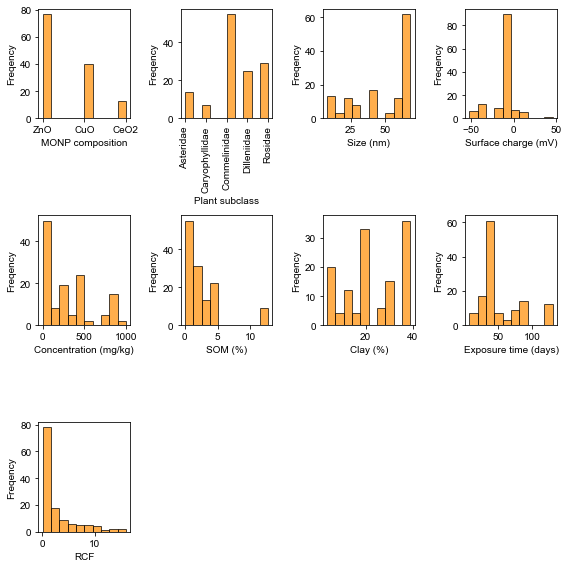

In [3]:
# %% plot data histogram
plt.figure(figsize=(8,8))
plt.style.use('default')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

for i in range(1,10,1):
    plt.subplot(3,4,i)
    plt.hist(data.iloc[:,i-1], facecolor="#FF8C00", edgecolor="black", alpha=0.7)
    plt.xlabel(data.columns[i-1])
    plt.ylabel("Freqency")
    if i==2:
        plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig("./RCF_LabelEncoder/data_single_visual.jpg",dpi=600,bbox_inches='tight')

In [4]:
data.loc[:,'MONP composition'].value_counts()

ZnO     77
CuO     40
CeO2    13
Name: MONP composition, dtype: int64

In [5]:
data.loc[:,'Plant subclass'].value_counts()

Commelinidae      55
Rosidae           29
Dilleniidae       25
Asteridae         14
Caryophyllidae     7
Name: Plant subclass, dtype: int64

In [6]:
data_label = data.copy()
le = LabelEncoder()
le.fit(data_label['MONP composition'])
data_label['MONP composition'] = le.transform(data_label['MONP composition'])
print(list(le.inverse_transform([0,1,2])))
le = LabelEncoder()
le.fit(data_label['Plant subclass'])
data_label['Plant subclass'] = le.transform(data_label['Plant subclass'])
print(list(le.inverse_transform([0,1,2,3,4])))
data_label

['CeO2', 'CuO', 'ZnO']
['Asteridae', 'Caryophyllidae', 'Commelinidae', 'Dilleniidae', 'Rosidae']


,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days),RCF
0,2,0,68.000000,-10.0,900.0,1.13,39.0,35.0,0.227778
1,2,0,68.000000,-10.0,900.0,1.13,39.0,35.0,0.288889
2,2,0,68.000000,-10.0,450.0,1.13,39.0,35.0,0.355556
3,2,0,68.000000,-10.0,450.0,1.13,39.0,35.0,0.555556
4,2,0,68.000000,-10.0,225.0,1.13,39.0,35.0,0.666667
...,...,...,...,...,...,...,...,...,...
125,1,4,50.000000,-52.0,50.0,1.59,26.0,120.0,0.210000
126,1,4,25.000000,-52.0,50.0,1.59,26.0,120.0,0.250000
127,0,4,16.299999,13.8,100.0,1.10,13.0,84.0,0.120000
128,0,4,16.299999,13.8,200.0,1.10,13.0,84.0,0.130000


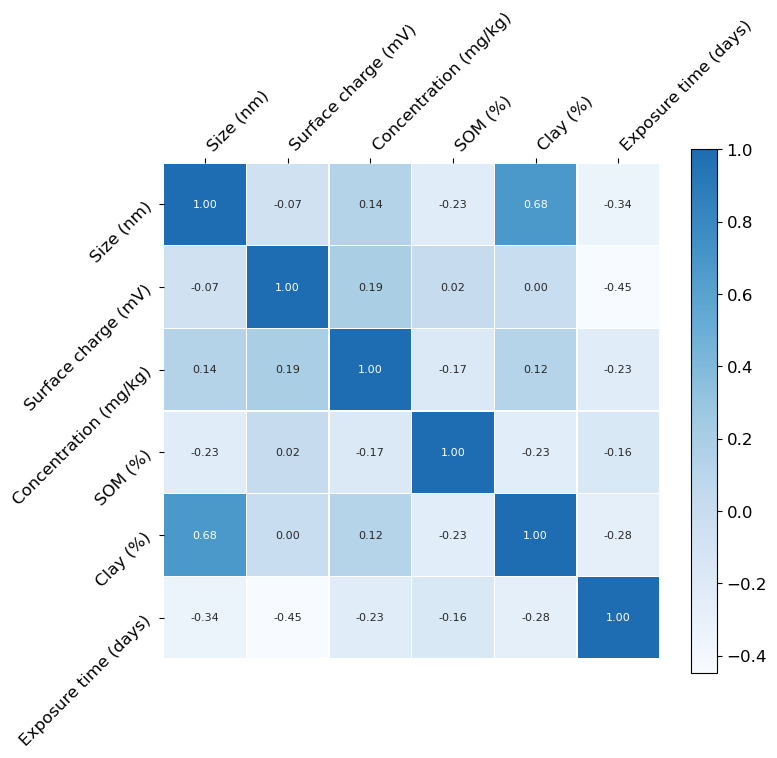

In [7]:
data_corr = data_label.copy()
data_corr = data_corr.drop(['RCF','MONP composition','Plant subclass'], axis=1)
corr = data_corr.corr()

fig, ax= plt.subplots(figsize = (8, 8))
plt.style.use('default')

h=sns.heatmap(corr, cmap='Blues',  square=True, center=0.5,
            fmt=".2f", annot=True, linewidths=0.4, ax=ax, cbar=False,annot_kws={'size':8})

cb = h.figure.colorbar(h.collections[0],shrink=0.85) #colorbar
cb.ax.tick_params(labelsize=12)  # colorbar fondsize
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='left',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45,horizontalalignment='right',fontsize=12)

fig.savefig("./RCF_LabelEncoder/data_corr.jpg",dpi=600,bbox_inches='tight')

In [8]:
scaler = MinMaxScaler()
scaler.fit(data_label)
data_visual = data_label.copy()
data_visual.iloc[:,:] = scaler.transform(data_label)
#data_visual.to_excel("./RCF_data_visual.xlsx")
data_visual

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days),RCF
0,1.0,0.0,1.000000,0.428135,0.899900,0.086098,1.000000,0.225806,0.009780
1,1.0,0.0,1.000000,0.428135,0.899900,0.086098,1.000000,0.225806,0.013617
2,1.0,0.0,1.000000,0.428135,0.449449,0.086098,1.000000,0.225806,0.017802
3,1.0,0.0,1.000000,0.428135,0.449449,0.086098,1.000000,0.225806,0.030359
4,1.0,0.0,1.000000,0.428135,0.224224,0.086098,1.000000,0.225806,0.037335
...,...,...,...,...,...,...,...,...,...
125,0.5,1.0,0.700000,0.000000,0.049049,0.122433,0.631728,0.911290,0.008664
126,0.5,1.0,0.283333,0.000000,0.049049,0.122433,0.631728,0.911290,0.011175
127,0.0,1.0,0.138333,0.670744,0.099099,0.083728,0.263456,0.620968,0.003014
128,0.0,1.0,0.138333,0.670744,0.199199,0.083728,0.263456,0.620968,0.003641


In [9]:
X = data.drop(['RCF'], axis=1)
Y = data['RCF']
X.head(5)

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days)
0,ZnO,Asteridae,68.0,-10.0,900.0,1.13,39.0,35.0
1,ZnO,Asteridae,68.0,-10.0,900.0,1.13,39.0,35.0
2,ZnO,Asteridae,68.0,-10.0,450.0,1.13,39.0,35.0
3,ZnO,Asteridae,68.0,-10.0,450.0,1.13,39.0,35.0
4,ZnO,Asteridae,68.0,-10.0,225.0,1.13,39.0,35.0


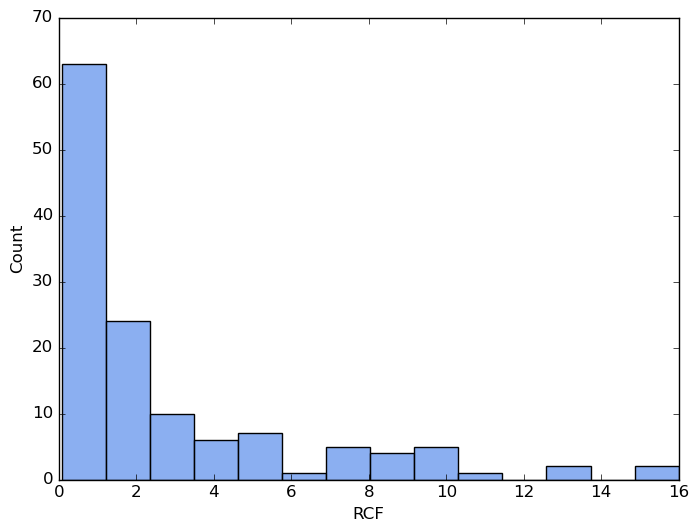

In [10]:
figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
sns.histplot(Y,color='#6495ED')
plt.xlabel('RCF')
figure.savefig("./RCF_LabelEncoder/RCF.jpg",dpi=600,bbox_inches='tight')

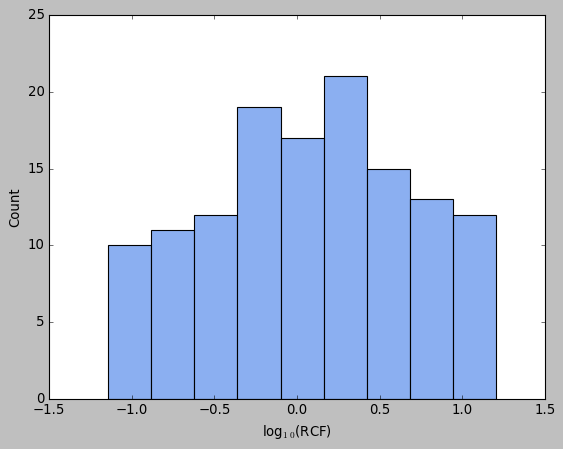

In [11]:
# log10 transform the RCF
Y_log = np.log10(Y)
figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
sns.histplot(Y_log,color='#6495ED')
plt.xlabel('log'+'${_1}$'+'${_0}$'+'(RCF)')
figure.savefig("./RCF_LabelEncoder/RCF_log.jpg",dpi=600,bbox_inches='tight')

In [12]:
# comment out this code if for RCF modeling
Y = Y_log
Y

0     -0.642489
1     -0.539269
2     -0.449093
3     -0.255272
4     -0.176091
         ...   
125   -0.677781
126   -0.602060
127   -0.920819
128   -0.886057
129   -0.795880
Name: RCF, Length: 130, dtype: float32

In [13]:
# Divide the data into 13 categories and get the classification labels
Y_Stratified_interval = pd.qcut(Y,q=13)
Y_Stratified = pd.qcut(Y,q=13,labels=False)
Y_Stratified.value_counts()

3     11
2     10
6     10
8     10
10    10
11    10
12    10
5     10
7     10
1     10
9     10
0     10
4      9
Name: RCF, dtype: int64

In [14]:
Y_Stratified_interval

0      (-0.644, -0.436]
1      (-0.644, -0.436]
2      (-0.644, -0.436]
3      (-0.301, -0.158]
4      (-0.301, -0.158]
             ...       
125    (-0.876, -0.644]
126    (-0.644, -0.436]
127    (-1.144, -0.876]
128    (-1.144, -0.876]
129    (-0.876, -0.644]
Name: RCF, Length: 130, dtype: category
Categories (13, interval[float64, right]): [(-1.144, -0.876] < (-0.876, -0.644] < (-0.644, -0.436] < (-0.436, -0.301] ... (0.419, 0.585] < (0.585, 0.76] < (0.76, 0.961] < (0.961, 1.204]]

In [15]:
# The reason why there are 11 data in category 3 is that the endpoint data has two values with the same value. The processing method is to assign one of them to category 4.
Y_Stratified[np.argwhere(Y.values==sorted(Y.values)[39])[1][0]] = 4 
Y_Stratified.value_counts()

2     10
4     10
6     10
8     10
10    10
11    10
12    10
5     10
7     10
1     10
3     10
9     10
0     10
Name: RCF, dtype: int64

In [16]:
# comment out this code if for random split
# 80-20 train-test ratio

# run the following code from 1 to 10 (random_state) and record model performance and hyperparameters
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=6) 
# the sixth dataset split was used for model interpretation
for train,test in sss.split(X, Y_Stratified):
    X_cv = X.iloc[train]
    Y_cv = Y.iloc[train]
    X_test = X.iloc[test]
    Y_test = Y.iloc[test]
X_cv

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days)
91,ZnO,Dilleniidae,68.0,-10.00,20.0,1.69,18.0,35.0
107,ZnO,Rosidae,68.0,-10.00,225.0,1.13,39.0,35.0
31,CuO,Commelinidae,43.0,-10.50,500.0,4.15,31.9,60.0
102,CeO2,Rosidae,8.0,2.19,250.0,4.20,5.0,52.0
40,CuO,Commelinidae,43.0,-10.50,100.0,4.15,31.9,7.0
...,...,...,...,...,...,...,...,...
54,ZnO,Commelinidae,68.0,-10.00,450.0,1.69,18.0,35.0
84,ZnO,Dilleniidae,68.0,-10.00,450.0,1.13,39.0,35.0
36,CuO,Commelinidae,43.0,-10.50,500.0,4.15,31.9,7.0
28,ZnO,Commelinidae,24.0,-2.22,400.0,0.04,3.7,84.0


In [17]:
Y_cv.head(5)

91     1.000000
107   -0.875061
31    -0.346788
102   -1.142668
40     0.414973
Name: RCF, dtype: float32

In [18]:
Y_test.mean()

0.06961879134178162

In [19]:
np.save('X_cv_index.npy',X_cv.index)
np.save('X_test_index.npy',X_test.index)

In [20]:
X_label = X.copy()
X_label['MONP composition'] = X_label['MONP composition'].cat.codes
X_label['Plant subclass'] = X_label['Plant subclass'].cat.codes
X_label

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days)
0,2,0,68.000000,-10.0,900.0,1.13,39.0,35.0
1,2,0,68.000000,-10.0,900.0,1.13,39.0,35.0
2,2,0,68.000000,-10.0,450.0,1.13,39.0,35.0
3,2,0,68.000000,-10.0,450.0,1.13,39.0,35.0
4,2,0,68.000000,-10.0,225.0,1.13,39.0,35.0
...,...,...,...,...,...,...,...,...
125,1,4,50.000000,-52.0,50.0,1.59,26.0,120.0
126,1,4,25.000000,-52.0,50.0,1.59,26.0,120.0
127,0,4,16.299999,13.8,100.0,1.10,13.0,84.0
128,0,4,16.299999,13.8,200.0,1.10,13.0,84.0


In [21]:
X_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MONP composition       130 non-null    int8   
 1   Plant subclass         130 non-null    int8   
 2   Size (nm)              130 non-null    float32
 3   Surface charge (mV)    130 non-null    float32
 4   Concentration (mg/kg)  130 non-null    float32
 5   SOM (%)                130 non-null    float32
 6   Clay (%)               130 non-null    float32
 7   Exposure time (days)   130 non-null    float32
dtypes: float32(6), int8(2)
memory usage: 3.4 KB


In [22]:
X_label_cv = X_label.loc[X_cv.index]
X_label_test = X_label.loc[X_test.index]
Y_label_cv = Y.loc[X_cv.index]
Y_label_test = Y.loc[X_test.index]

X_label_cv.head(5)

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days)
91,2,3,68.0,-10.00,20.0,1.69,18.0,35.0
107,2,4,68.0,-10.00,225.0,1.13,39.0,35.0
31,1,2,43.0,-10.50,500.0,4.15,31.9,60.0
102,0,4,8.0,2.19,250.0,4.20,5.0,52.0
40,1,2,43.0,-10.50,100.0,4.15,31.9,7.0


# 1. LightGBM

In [23]:
# For each dataset split, the hyperparameter search is done manually in four steps
parameter = {

    # 1.
    # "min_data_in_leaf":np.arange(1,20,1),
    # "min_sum_hessian_in_leaf": np.arange(1,20,1),
    
    # 2.
    # "max_bin":  np.arange(1,30,1),
    
    # 3.
    # "max_depth":np.arange(1,11,1),
    # "num_leaves": np.arange(2,21,1),

    # 4.
    # "learning_rate": np.arange(0.001,0.1,0.001),

}

model_gs = lgb.LGBMRegressor(n_jobs=-1,n_estimators=1000,max_cat_to_onehot=6,
                              min_data_in_leaf=1,min_sum_hessian_in_leaf=15,
                              max_bin=7, 
                              max_depth=4,num_leaves=5,
                              learning_rate=0.084
                            )

                
grid_search = GridSearchCV(model_gs, param_grid = parameter, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_label_cv, Y_label_cv,categorical_feature=['MONP composition','Plant subclass'])

print('best score: %.2f '%grid_search.best_score_)
print('best_params:', grid_search.best_params_)

LGBM_Gs_best = grid_search.best_estimator_

print('RMSE: %.2f ' %abs(sum(cross_val_score(LGBM_Gs_best, X_label_cv, Y_label_cv, cv=5, scoring='neg_root_mean_squared_error'))/5))

Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15
best score: 0.71 
best_params: {}
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15, min_child_weight

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15
R2_train: 0.94 
RMSE_train: 0.15 
R2_test: 0.80 
RMSE_test: 0.27 


Using categorical_feature in Dataset.


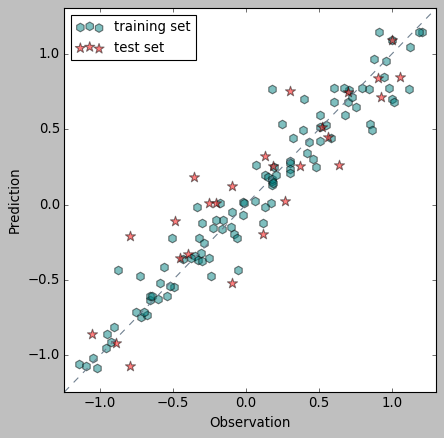

In [24]:
# random state: 6
model = lgb.LGBMRegressor(n_jobs=-1,n_estimators=1000,max_cat_to_onehot=6,
                              min_data_in_leaf=1,min_sum_hessian_in_leaf=15,
                              max_bin=13, 
                              max_depth=3,num_leaves=5,
                              learning_rate=0.068
                         )

# model = lgb.LGBMRegressor(n_jobs=-1,n_estimators=1000,max_cat_to_onehot=6,
#                              min_data_in_leaf=1,min_sum_hessian_in_leaf=17,
#                              max_bin=15, 
#                              max_depth=3,num_leaves=4,
#                              learning_rate=0.087,
#                          )
model.fit(X_label_cv, Y_label_cv,categorical_feature=['MONP composition','Plant subclass'])
LightGBM_importance_split = model.feature_importances_


Y_label_pred = model.predict(X_label_test)
Y_label_cv_pred = model.predict(X_label_cv)

print('R2_train: %.2f ' %r2_score(Y_label_cv, Y_label_cv_pred))  # train set R2 
print('RMSE_train: %.2f ' %sqrt(mean_squared_error(Y_label_cv, Y_label_cv_pred)))  # train set RMSE 
print('R2_test: %.2f ' %r2_score(Y_label_test, Y_label_pred))  # test set R2 
print('RMSE_test: %.2f ' %sqrt(mean_squared_error(Y_label_test, Y_label_pred)))  # test set RMSE 


figure = plt.figure(figsize=(6,6)) 
plt.style.use('classic')

plt.xlim(min(Y)-0.1, max(Y)+0.1)
plt.ylim(min(Y)-0.1, max(Y)+0.1)
plt.plot([min(Y)-0.1,max(Y)+0.1],[min(Y)-0.1,max(Y)+0.1],color="slategrey",linestyle='--')
plt.scatter(Y_label_cv, Y_label_cv_pred,marker="h", c='teal', s=60, alpha=0.5,label="training set")   
plt.scatter(Y_label_test, Y_label_pred,marker="*",c='red', s=90, alpha=0.5,label="test set")
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.legend(loc=0,fontsize=12)
plt.plot()
figure.savefig("./RCF_LabelEncoder/LightGBM_Predcitons_observations_label.jpg",dpi=600,bbox_inches='tight')

# 2. Feature importance

## 2.1 LightGBM

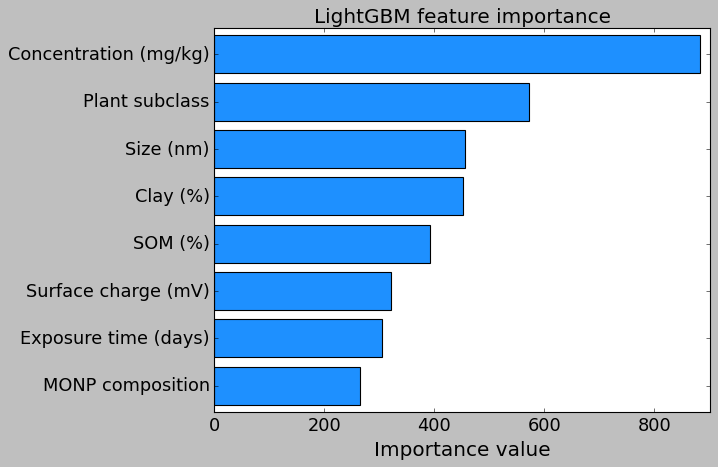

In [25]:
figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
plt.rcParams['font.size'] ='16'
plt.margins(0.02)
sorted_idx = LightGBM_importance_split.argsort()
sorted_features = X_cv.columns[sorted_idx]
fature_name = X_cv.columns
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(fature_name[int(itemindex)])

plt.barh(feature_this_plot,
         LightGBM_importance_split[sorted_idx], align='center', color="#1E90FF")

plt.title('LightGBM feature importance',fontsize=18)
plt.xlabel('Importance value',fontsize=18)

figure.savefig("./RCF_LabelEncoder/LightGBM_importance_split.jpg",dpi=600,bbox_inches='tight')

## 2.2 Permutation

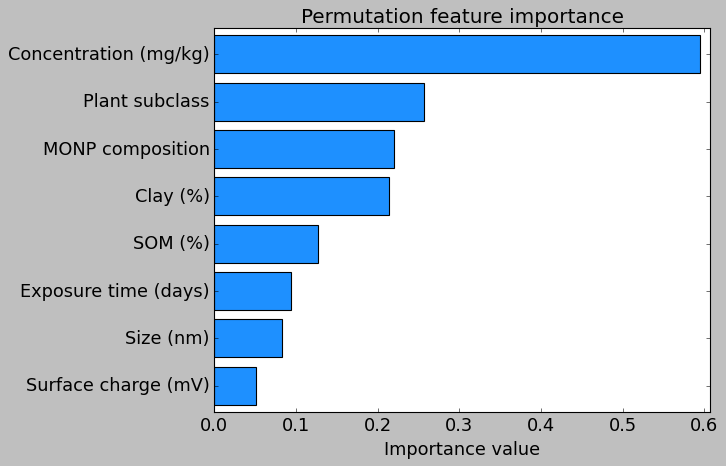

In [26]:
result = permutation_importance(model, X_label_cv, Y_label_cv, scoring='r2', n_repeats=10, random_state=0, n_jobs=-1)
Permutation_importance = result.importances_mean

figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
plt.rcParams['font.size'] ='16'
plt.margins(0.02)
sorted_idx = Permutation_importance.argsort()
sorted_features = X_cv.columns[sorted_idx]
fature_name = X_cv.columns
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(fature_name[int(itemindex)])

plt.barh(feature_this_plot,
         Permutation_importance[sorted_idx], align='center', color="#1E90FF")

plt.title('Permutation feature importance',fontsize=18)
plt.xlabel('Importance value',fontsize=16)

figure.savefig("./RCF_LabelEncoder/Permutation_importance.jpg",dpi=600,bbox_inches='tight')

## 2.3 SHAP

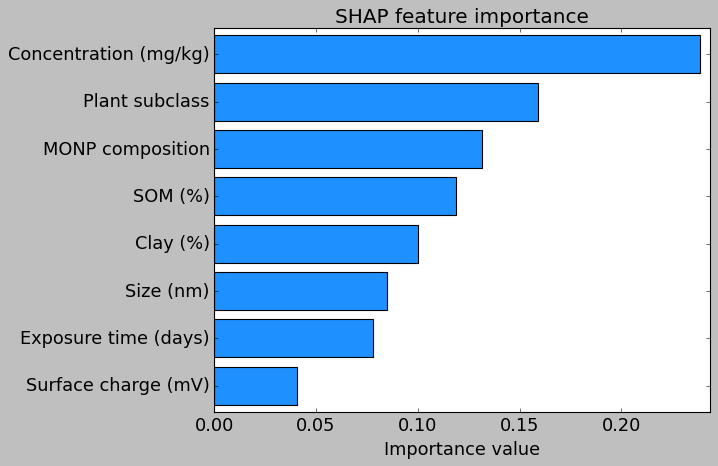

In [27]:
explainer = shap.TreeExplainer(model=model, data=None, model_output='raw', feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_label_cv)
global_shap_values = np.abs(shap_values).mean(0)

figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
plt.rcParams['font.size'] ='16'
plt.margins(0.02)
sorted_idx = global_shap_values.argsort()
sorted_features = X_label_cv.columns[sorted_idx]
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(fature_name[int(itemindex)])

plt.barh(feature_this_plot,
         global_shap_values[sorted_idx], align='center', color="#1E90FF")

plt.title('SHAP feature importance',fontsize=18)
plt.xlabel('Importance value',fontsize=16)
figure.savefig("./RCF_LabelEncoder/Shap_importance.jpg",dpi=600,bbox_inches='tight')

## 2.4 Importance summary

In [28]:
# Calculate the relative importance, the maximum is 1
LightGBM_importance_split_relative = LightGBM_importance_split/max(LightGBM_importance_split)
Permutation_importance_relative = Permutation_importance/max(Permutation_importance)
shap_values__relative = global_shap_values/max(global_shap_values)

# Sort by the sum of relative importance
importance_sum = LightGBM_importance_split_relative+Permutation_importance_relative+shap_values__relative
sorted_idx_sum = importance_sum.argsort()
sorted_features = X_cv.columns[sorted_idx_sum][::-1]

np.save('sorted_features.npy',sorted_features.tolist())

importance_df = pd.DataFrame({'Feature':X_cv.columns[sorted_idx_sum],
                    'LightGBM (split)':LightGBM_importance_split_relative[sorted_idx_sum],
                    'Permutatio':Permutation_importance_relative[sorted_idx_sum],
                    'SHAP':shap_values__relative[sorted_idx_sum]},
                    )
importance_df

,Feature,LightGBM (split),Permutatio,SHAP
0,Surface charge (mV),0.363122,0.084945,0.170872
1,Exposure time (days),0.345023,0.158631,0.327325
2,Size (nm),0.515837,0.139149,0.354951
3,SOM (%),0.444570,0.213707,0.497408
4,MONP composition,0.299774,0.369304,0.551232
5,Clay (%),0.511312,0.359166,0.419026
6,Plant subclass,0.648190,0.431292,0.666657
7,Concentration (mg/kg),1.000000,1.000000,1.000000


In [29]:
sorted_features

Index(['Concentration (mg/kg)', 'Plant subclass', 'Clay (%)',
       'MONP composition', 'SOM (%)', 'Size (nm)', 'Exposure time (days)',
       'Surface charge (mV)'],
      dtype='object')

In [30]:
importance_df

,Feature,LightGBM (split),Permutatio,SHAP
0,Surface charge (mV),0.363122,0.084945,0.170872
1,Exposure time (days),0.345023,0.158631,0.327325
2,Size (nm),0.515837,0.139149,0.354951
3,SOM (%),0.444570,0.213707,0.497408
4,MONP composition,0.299774,0.369304,0.551232
5,Clay (%),0.511312,0.359166,0.419026
6,Plant subclass,0.648190,0.431292,0.666657
7,Concentration (mg/kg),1.000000,1.000000,1.000000


In [31]:
importance_df = pd.DataFrame(columns=('Feature','Method','Relative importance value'))
n_feature = len(X_cv.columns)

for i in range(0,n_feature):
    importance_df.loc[i,'Feature'] = X_cv.columns[sorted_idx_sum][-i-1]
    importance_df.loc[i,'Method'] = 'LightGBM'
    importance_df.loc[i,'Relative importance value'] = LightGBM_importance_split_relative[sorted_idx_sum][-i-1]

for i in range(0,n_feature):
    importance_df.loc[i+n_feature,'Feature'] = X_cv.columns[sorted_idx_sum][-i-1]
    importance_df.loc[i+n_feature,'Method'] = 'Permutation'
    importance_df.loc[i+n_feature,'Relative importance value'] = Permutation_importance_relative[sorted_idx_sum][-i-1]
    
for i in range(0,n_feature):
    importance_df.loc[i+n_feature*2,'Feature'] = X_cv.columns[sorted_idx_sum][-i-1]
    importance_df.loc[i+n_feature*2,'Method'] = 'SHAP'
    importance_df.loc[i+n_feature*2,'Relative importance value'] = shap_values__relative[sorted_idx_sum][-i-1]

LightGBM_split_sorted_value = sorted(importance_df.loc[:,'Relative importance value'][0:n_feature].values,reverse=True)
Permutation_sorted_value = sorted(importance_df.loc[:,'Relative importance value'][n_feature*1:n_feature*2].values,reverse=True)
SHAP_sorted_value = sorted(importance_df.loc[:,'Relative importance value'][n_feature*2:n_feature*3].values,reverse=True)

In [32]:
annotate_LightGBM_split = []
annotate_LightGBM_gain = []
annotate_Permutation = []
annotate_SHAP = []

for i in range(0,n_feature,1):
    annotate_LightGBM_split.append(LightGBM_split_sorted_value.index(importance_df.loc[:,'Relative importance value'][0:n_feature].values[i])+1)
    annotate_Permutation.append(Permutation_sorted_value.index(importance_df.loc[:,'Relative importance value'][n_feature:n_feature*2].values[i])+1)
    annotate_SHAP.append(SHAP_sorted_value.index(importance_df.loc[:,'Relative importance value'][n_feature*2:n_feature*3].values[i])+1)
    
annotate_value = np.hstack((annotate_LightGBM_split, annotate_LightGBM_gain, annotate_Permutation,annotate_SHAP))
annotate_value

array([1., 2., 4., 8., 5., 3., 7., 6., 1., 2., 4., 3., 5., 7., 6., 8., 1.,
       2., 5., 3., 4., 6., 7., 8.])

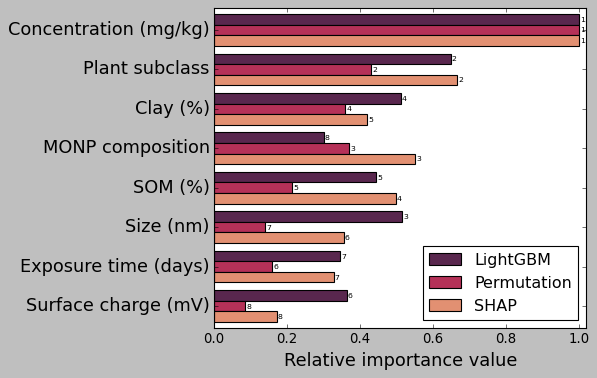

In [33]:
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(fature_name[int(itemindex)])

figure = plt.figure(figsize=(6,5))
plt.style.use('classic')
bar = sns.barplot(data = importance_df,y='Feature',x='Relative importance value',hue='Method',palette="rocket")
bar.set_ylabel('',fontsize=16)
bar.set_xlabel('Relative importance value',fontsize=16)
bar.set_yticklabels(feature_this_plot,fontsize=16)
plt.legend(loc='lower right')
i=0
plt.margins(0.02)
for p in bar.patches:
    bar.annotate("%d" %annotate_value[i], xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(1, -0.5), textcoords='offset points', ha="left", va="center",fontsize=7)
    i=i+1
figure.savefig("./RCF_LabelEncoder/Importance_summary.jpg",dpi=600,bbox_inches='tight')

In [34]:
feature_sorted_all = feature_this_plot
feature_sorted_all

['Concentration (mg/kg)',
 'Plant subclass',
 'Clay (%)',
 'MONP composition',
 'SOM (%)',
 'Size (nm)',
 'Exposure time (days)',
 'Surface charge (mV)']

In [35]:
np.save('sorted_features.npy',feature_sorted_all)

# 3. SHAP feature effect

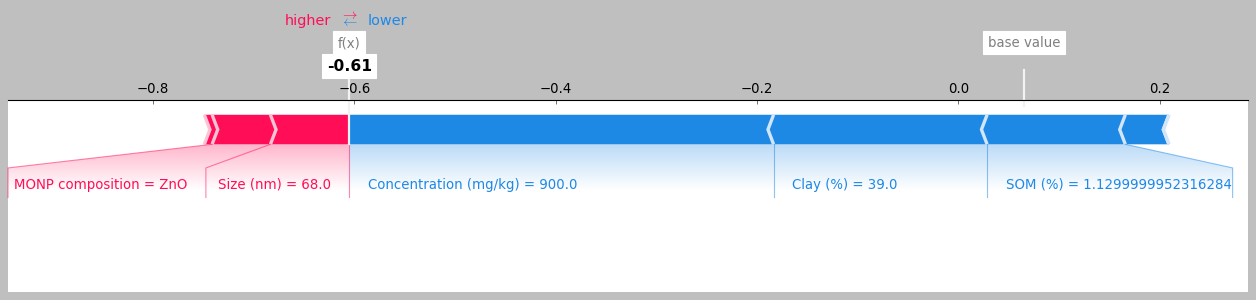

In [36]:
shap_values = explainer.shap_values(X_label)
ax=shap.force_plot(explainer.expected_value,
                shap_values[0, :],
                X.iloc[0,:], show=False, matplotlib=True)

ax.savefig("./RCF_LabelEncoder/Local_Shap_sample.jpg",dpi=600,bbox_inches='tight')

In [37]:
X

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days)
0,ZnO,Asteridae,68.000000,-10.0,900.0,1.13,39.0,35.0
1,ZnO,Asteridae,68.000000,-10.0,900.0,1.13,39.0,35.0
2,ZnO,Asteridae,68.000000,-10.0,450.0,1.13,39.0,35.0
3,ZnO,Asteridae,68.000000,-10.0,450.0,1.13,39.0,35.0
4,ZnO,Asteridae,68.000000,-10.0,225.0,1.13,39.0,35.0
...,...,...,...,...,...,...,...,...
125,CuO,Rosidae,50.000000,-52.0,50.0,1.59,26.0,120.0
126,CuO,Rosidae,25.000000,-52.0,50.0,1.59,26.0,120.0
127,CeO2,Rosidae,16.299999,13.8,100.0,1.10,13.0,84.0
128,CeO2,Rosidae,16.299999,13.8,200.0,1.10,13.0,84.0


In [38]:
X_label

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days)
0,2,0,68.000000,-10.0,900.0,1.13,39.0,35.0
1,2,0,68.000000,-10.0,900.0,1.13,39.0,35.0
2,2,0,68.000000,-10.0,450.0,1.13,39.0,35.0
3,2,0,68.000000,-10.0,450.0,1.13,39.0,35.0
4,2,0,68.000000,-10.0,225.0,1.13,39.0,35.0
...,...,...,...,...,...,...,...,...
125,1,4,50.000000,-52.0,50.0,1.59,26.0,120.0
126,1,4,25.000000,-52.0,50.0,1.59,26.0,120.0
127,0,4,16.299999,13.8,100.0,1.10,13.0,84.0
128,0,4,16.299999,13.8,200.0,1.10,13.0,84.0


In [39]:
X_label.iloc[0,:]

MONP composition           2.00
Plant subclass             0.00
Size (nm)                 68.00
Surface charge (mV)      -10.00
Concentration (mg/kg)    900.00
SOM (%)                    1.13
Clay (%)                  39.00
Exposure time (days)      35.00
Name: 0, dtype: float32

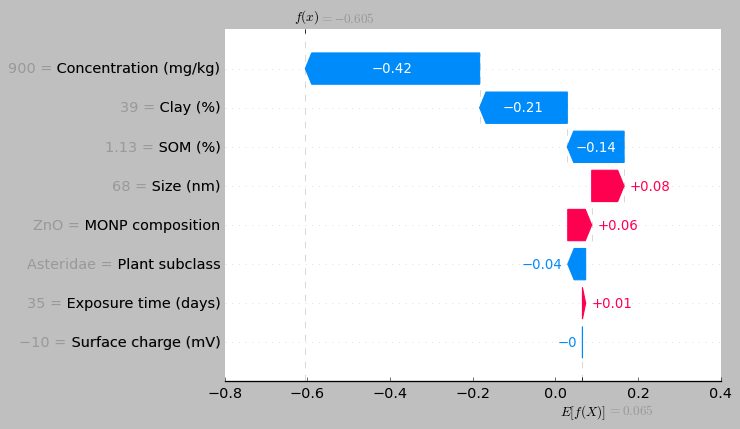

In [40]:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names
        

shap_object = ShapObject(base_values = explainer.expected_value,
                         values = shap_values[0],
                         feature_names = X_label.columns,
                         data = X.iloc[0,:])


figure = plt.figure()
shap.waterfall_plot(shap_object, show=False)

figure.savefig("./RCF_LabelEncoder/waterfall_plot_0.jpg",dpi=600,bbox_inches='tight')

In [41]:
shap_interaction_values = shap.TreeExplainer(model=model).shap_interaction_values(X_label)

In [42]:
np.array(shap_interaction_values).shape

(130, 8, 8)

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

In [44]:
X_label

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days)
0,2,0,68.000000,-10.0,900.0,1.13,39.0,35.0
1,2,0,68.000000,-10.0,900.0,1.13,39.0,35.0
2,2,0,68.000000,-10.0,450.0,1.13,39.0,35.0
3,2,0,68.000000,-10.0,450.0,1.13,39.0,35.0
4,2,0,68.000000,-10.0,225.0,1.13,39.0,35.0
...,...,...,...,...,...,...,...,...
125,1,4,50.000000,-52.0,50.0,1.59,26.0,120.0
126,1,4,25.000000,-52.0,50.0,1.59,26.0,120.0
127,0,4,16.299999,13.8,100.0,1.10,13.0,84.0
128,0,4,16.299999,13.8,200.0,1.10,13.0,84.0


feature_names=["Concentration (mg/kg)","MONP composition","Plant subclass","Clay (%)",
                                 "SOM (%)","Exposure time (days)","Size (nm)","Surface charge (mV)"],

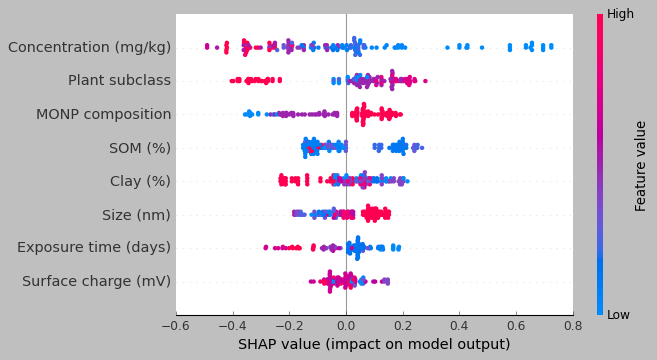

In [45]:
figure = plt.figure()
shap.summary_plot(shap_values, features=X_label, max_display=10)
figure.savefig("./RCF_LabelEncoder/Local_Shap_summary_feature.jpg",dpi=600,bbox_inches='tight')

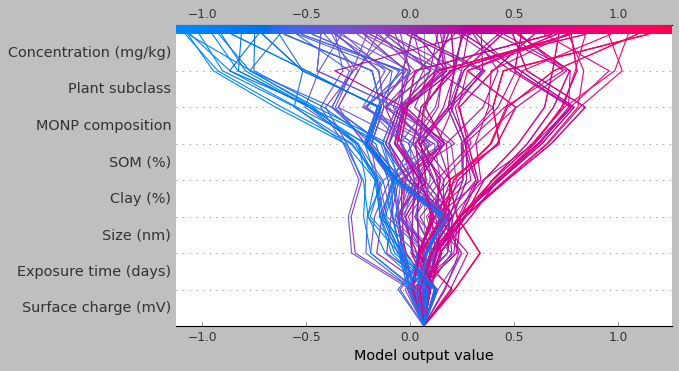

In [46]:
figure = plt.figure()
shap.decision_plot(explainer.expected_value,
                   shap_values, X_label.columns)
figure.savefig("./RCF_LabelEncoder/Local_Shap_summary_decesion.jpg",dpi=600,bbox_inches='tight')

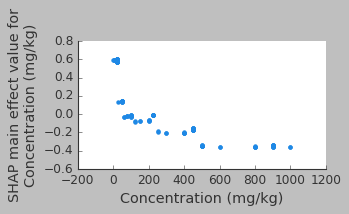

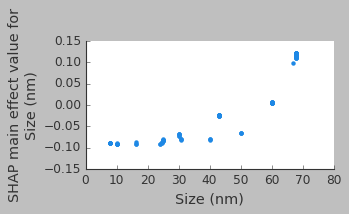

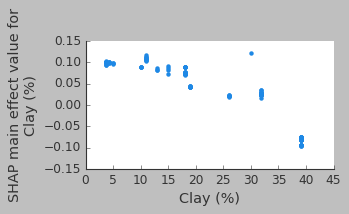

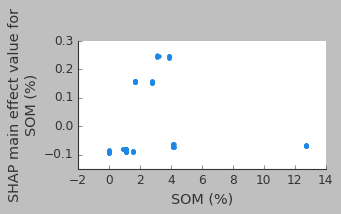

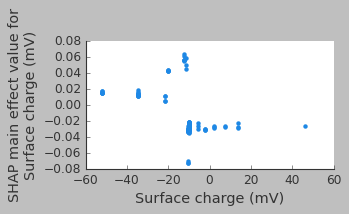

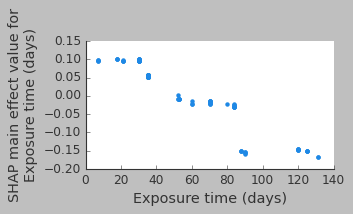

In [47]:
for feature in ['Concentration (mg/kg)','Size (nm)','Clay (%)','SOM (%)','Surface charge (mV)','Exposure time (days)']:
    
    fig, ax = plt.subplots()
    shap.dependence_plot((feature, feature), shap_interaction_values, X_label, show=False,display_features=X, ax=ax)
    plt.gcf().set_size_inches(4, 2)
    feature_save = feature[0:4]
    fig.savefig("./RCF_LabelEncoder/Main_effects_%s.jpg"%(feature_save),dpi=600,bbox_inches='tight')  

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


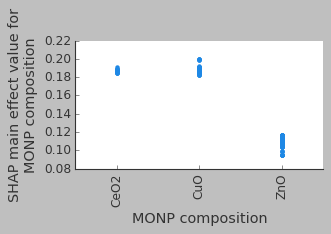

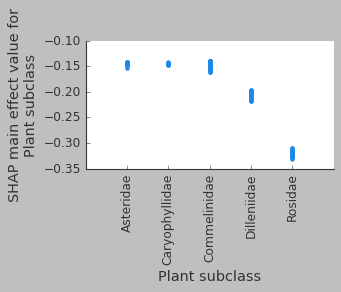

In [48]:
for feature in [ 'MONP composition','Plant subclass']:
    
    fig, ax = plt.subplots()
    shap.dependence_plot((feature, feature), shap_interaction_values, X_label, show=False,display_features=X, ax=ax)
    plt.gcf().set_size_inches(4, 2)
    
    
    feature_save = feature[0:4]
    fig.savefig("./RCF_LabelEncoder/Main_effects_%s.jpg"%(feature_save),dpi=600,bbox_inches='tight')  

feature = 'Plant subclass'
    
fig, ax = plt.subplots()
shap.dependence_plot((feature, feature), shap_interaction_values, X, show=False,display_features=X, ax=ax)
plt.gcf().set_size_inches(4, 2)

ax.set_xticks(range(0,6))
ax.set_xticklabels(['Dilleniidae','Asteridae','Caryophyllidae','Commelinidae',''],rotation=-45,ha ='left')     
    
feature_save = feature[0:4]
fig.savefig("./RCF_LabelEncoder/Main_effects_%s.jpg"%(feature_save),dpi=600,bbox_inches='tight')  

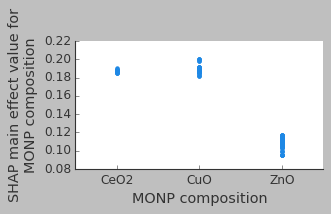

In [49]:
feature = 'MONP composition'
    
fig, ax = plt.subplots()
shap.dependence_plot((feature, feature), shap_interaction_values, X_label, show=False,display_features=X, ax=ax)
plt.gcf().set_size_inches(4, 2)

ax.set_xticks(range(0,3))
ax.set_xticklabels(['CeO2','CuO','ZnO'],rotation=0)     
    
feature_save = feature[0:4]
fig.savefig("./RCF_LabelEncoder/Main_effects_%s.jpg"%(feature_save),dpi=600,bbox_inches='tight') 

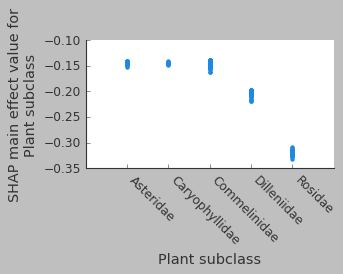

In [50]:
feature = 'Plant subclass'
    
fig, ax = plt.subplots()
shap.dependence_plot((feature, feature), shap_interaction_values, X_label, show=False,display_features=X, ax=ax)
plt.gcf().set_size_inches(4, 2)

ax.set_xticks(range(0,5))
ax.set_xticklabels(['Asteridae','Caryophyllidae','Commelinidae','Dilleniidae','Rosidae'],rotation=-45,ha ='left')     
    
feature_save = feature[0:4]
fig.savefig("./RCF_LabelEncoder/Main_effects_%s.jpg"%(feature_save),dpi=600,bbox_inches='tight')  

# 4. SHAP feature interactions

In [51]:
Category_feature = ['NP Composition','Plant subclass']
np.array(shap_values).shape

(130, 8)

In [52]:
feature_sorted_all

['Concentration (mg/kg)',
 'Plant subclass',
 'Clay (%)',
 'MONP composition',
 'SOM (%)',
 'Size (nm)',
 'Exposure time (days)',
 'Surface charge (mV)']

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


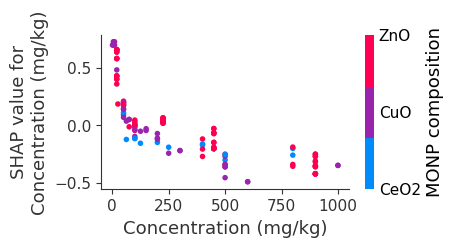

In [53]:
feature = 'Concentration (mg/kg)'

plt.style.use('default')
fig, ax = plt.subplots(figsize=(4, 2))

ax_shap = shap.dependence_plot(feature, shap_values, X_label,ax=ax, show=False,
                               display_features=X,)

plt.rcParams.update({'font.size': 5})


fig.savefig("./RCF_LabelEncoder/Effect_Concentration.jpg",dpi=600,bbox_inches='tight')

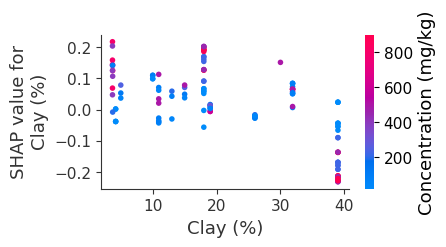

In [54]:
feature = 'Clay (%)'

plt.style.use('default')
fig, ax = plt.subplots(figsize=(4, 2))

ax_shap = shap.dependence_plot(feature, shap_values, X_label,ax=ax, show=False,
                               display_features=X,)

plt.rcParams.update({'font.size': 5})


fig.savefig("./RCF_LabelEncoder/Effect_Clay.jpg",dpi=600,bbox_inches='tight')

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


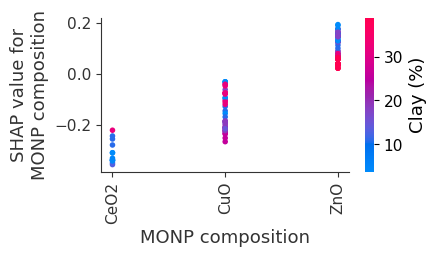

In [55]:
feature = 'MONP composition'

plt.style.use('default')
fig, ax = plt.subplots(figsize=(4, 2))

ax_shap = shap.dependence_plot(feature, shap_values, X_label,ax=ax, show=False,
                               display_features=X)

plt.rcParams.update({'font.size': 5})

fig.savefig("./RCF_LabelEncoder/Effect_MONP composition.jpg",dpi=600,bbox_inches='tight')

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


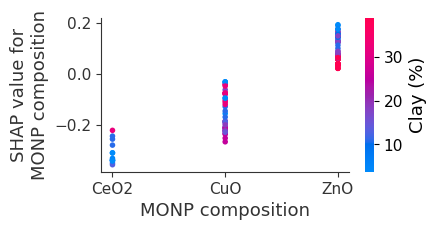

In [56]:
feature = 'MONP composition'

plt.style.use('default')
fig, ax = plt.subplots(figsize=(4, 2))

ax_shap = shap.dependence_plot(feature, shap_values, X_label,ax=ax, show=False,
                               display_features=X)

plt.rcParams.update({'font.size': 5})
ax.set_xticks(range(0,3))
ax.set_xticklabels(['CeO2', 'CuO', 'ZnO'],rotation=0)    

fig.savefig("./RCF_LabelEncoder/Effect_MONP composition.jpg",dpi=600,bbox_inches='tight')

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


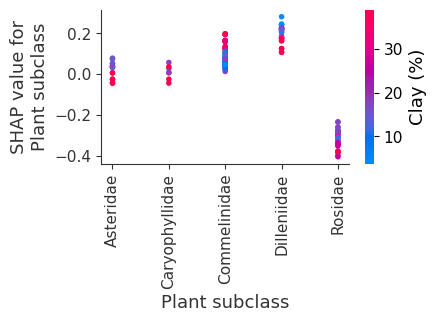

In [57]:
feature = 'Plant subclass'

plt.style.use('default')
fig, ax = plt.subplots(figsize=(4, 2))

ax_shap = shap.dependence_plot(feature, shap_values, X_label,ax=ax, show=False,
                               display_features=X)

plt.rcParams.update({'font.size': 5})

fig.savefig("./RCF_LabelEncoder/Effect_Plant subclass.jpg",dpi=600,bbox_inches='tight')

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


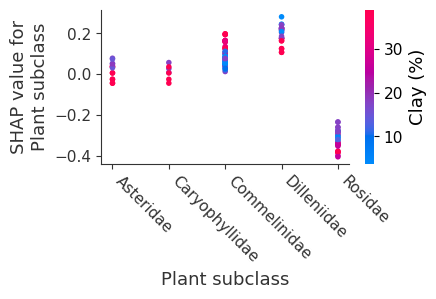

In [58]:
feature = 'Plant subclass'

plt.style.use('default')
fig, ax = plt.subplots(figsize=(4, 2))

ax_shap = shap.dependence_plot(feature, shap_values, X_label,ax=ax, show=False,
                               display_features=X)

plt.rcParams.update({'font.size': 5})
ax.set_xticks(range(0,5))
ax.set_xticklabels(['Asteridae', 'Caryophyllidae', 'Commelinidae', 'Dilleniidae', 'Rosidae'],rotation=-45,ha ='left') 

fig.savefig("./RCF_LabelEncoder/Effect_Plant subclass.jpg",dpi=600,bbox_inches='tight')

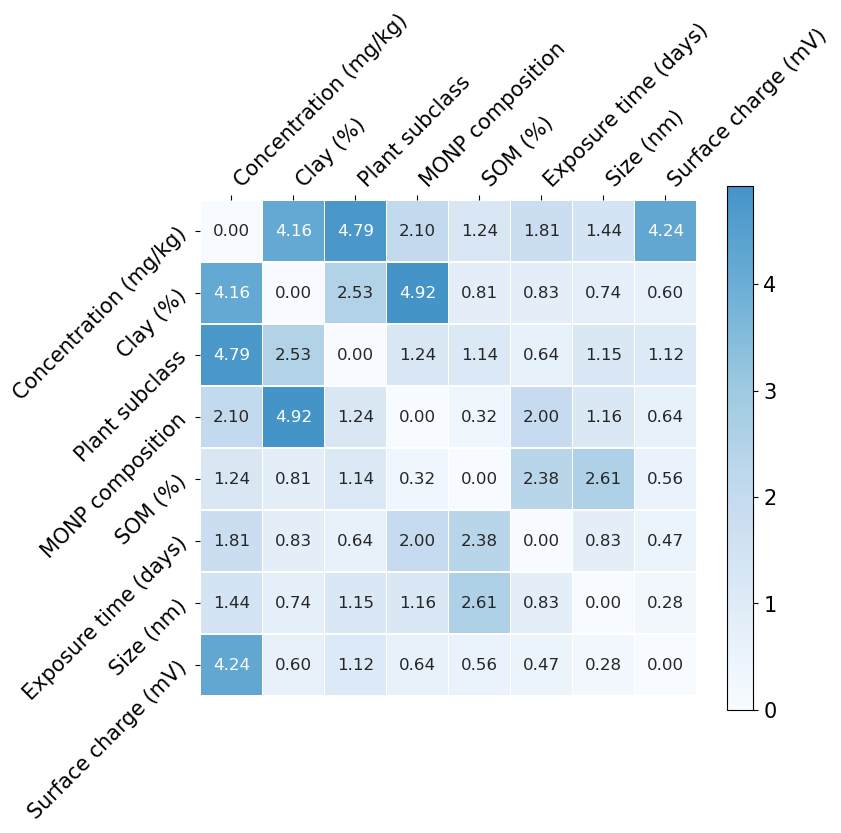

In [59]:
fig, ax= plt.subplots(figsize = (8, 8))
plt.style.use('default')
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
df_temp2 = pd.DataFrame(tmp2)
df_temp2.columns = X_label.columns[inds]
df_temp2.index = X_label.columns[inds]

h=sns.heatmap(df_temp2, cmap='Blues', square=True, center=4,
            fmt=".2f", annot=True, linewidths=0.4, ax=ax, cbar=False,annot_kws={'size':12})
cb = h.figure.colorbar(h.collections[0],shrink=0.85) #显示colorbar
cb.ax.tick_params(labelsize=15)  # 设置colorbar刻度字体大小。
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='left',fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45,horizontalalignment='right',fontsize=15)

fig.savefig("./RCF_LabelEncoder/Feature_interaction_summary_heatmap.jpg",dpi=600,bbox_inches='tight')

In [60]:
feature_sorted_all

['Concentration (mg/kg)',
 'Plant subclass',
 'Clay (%)',
 'MONP composition',
 'SOM (%)',
 'Size (nm)',
 'Exposure time (days)',
 'Surface charge (mV)']

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


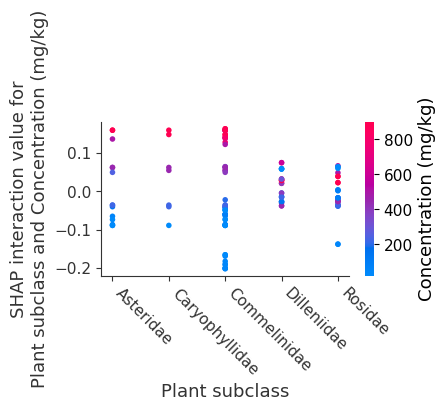

In [61]:
fig, ax = plt.subplots(figsize=(4, 2))
feature1 = 'Plant subclass'
feature2 = "Concentration (mg/kg)"
shap.dependence_plot((feature1, feature2),shap_interaction_values,X_label,ax=ax,show=False,display_features=X)
ax.set_xticks(range(0,5))
ax.set_xticklabels(['Asteridae', 'Caryophyllidae', 'Commelinidae', 'Dilleniidae', 'Rosidae'],rotation=-45,ha ='left') 
fig.savefig("./RCF_LabelEncoder/Interact_Plantsubclss_Conc.jpg",dpi=600,bbox_inches='tight')

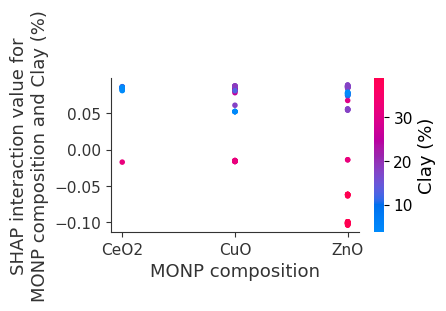

In [62]:
fig, ax = plt.subplots(figsize=(4, 2))
feature1 = 'MONP composition'
feature2 =  'Clay (%)'
shap.dependence_plot((feature1, feature2),shap_interaction_values,X_label,ax=ax,show=False,display_features=X)

ax.set_xticks(range(0,3))
ax.set_xticklabels(['CeO2', 'CuO', 'ZnO'],rotation=0)  

fig.savefig("./RCF_LabelEncoder/Interact_MONP_Clay.jpg",dpi=600,bbox_inches='tight')

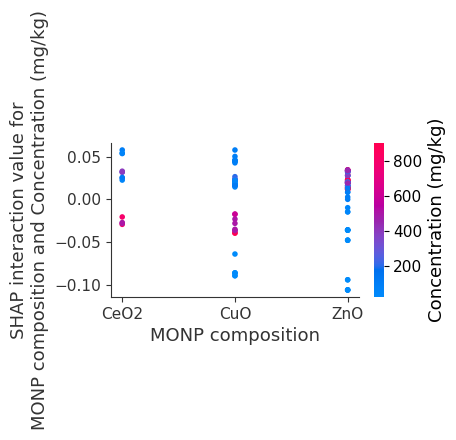

In [63]:
fig, ax = plt.subplots(figsize=(4, 2))
feature1 = 'MONP composition'
feature2 =  'Concentration (mg/kg)'
shap.dependence_plot((feature1, feature2),shap_interaction_values,X_label,ax=ax,show=False,display_features=X)

ax.set_xticks(range(0,3))
ax.set_xticklabels(['CeO2', 'CuO', 'ZnO'],rotation=0)  

fig.savefig("./RCF_LabelEncoder/Interact_MONP_Concentration.jpg",dpi=600,bbox_inches='tight')

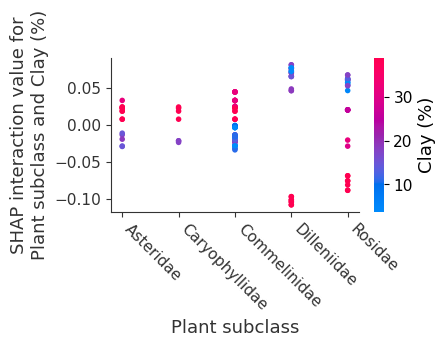

In [64]:
fig, ax = plt.subplots(figsize=(4, 2))
feature1 = 'Plant subclass'
feature2 = 'Clay (%)'
shap.dependence_plot((feature1, feature2),shap_interaction_values,X_label,ax=ax,show=False,display_features=X)
ax.set_xticks(range(0,5))
ax.set_xticklabels(['Asteridae', 'Caryophyllidae', 'Commelinidae', 'Dilleniidae', 'Rosidae'],rotation=-45,ha ='left') 

fig.savefig("./RCF_LabelEncoder/Interact_Plantsubclss_Clay.jpg",dpi=600,bbox_inches='tight')

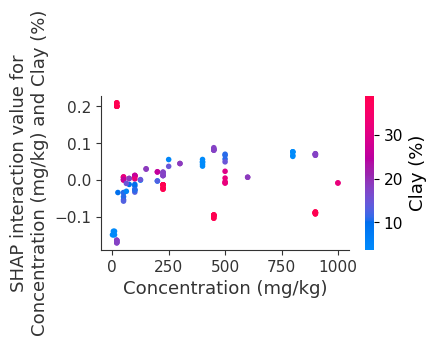

In [65]:
fig, ax = plt.subplots(figsize=(4, 2))
feature1 = 'Concentration (mg/kg)'
feature2 = "Clay (%)"
shap.dependence_plot((feature1, feature2),shap_interaction_values,X_label,ax=ax,show=False,display_features=X)

if feature1 in Category_feature:
    category_num = max(X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X.loc[random_index[np.where(X.loc[:,feature1]==i)][0],feature1])
        
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./RCF_LabelEncoder/Interact_Conc_Clay.jpg",dpi=600,bbox_inches='tight')

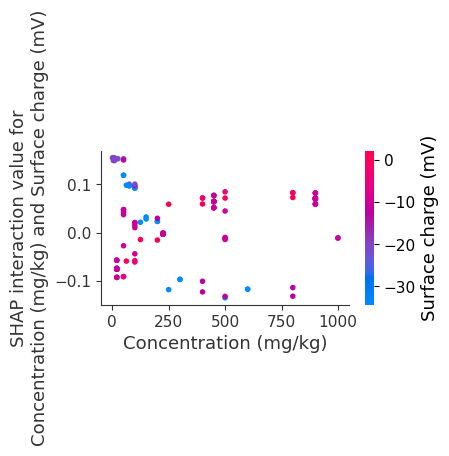

In [66]:
fig, ax = plt.subplots(figsize=(4, 2))
feature1 = 'Concentration (mg/kg)'
feature2 = "Surface charge (mV)"
shap.dependence_plot((feature1, feature2),shap_interaction_values,X_label,ax=ax,show=False,display_features=X)

if feature1 in Category_feature:
    category_num = max(X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X.loc[random_index[np.where(X.loc[:,feature1]==i)][0],feature1])
        
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./RCF_LabelEncoder/Interact_Conc_SC.jpg",dpi=600,bbox_inches='tight')

# 5. PDP and ICE feature effect

In [67]:
features = feature_sorted_all
features

['Concentration (mg/kg)',
 'Plant subclass',
 'Clay (%)',
 'MONP composition',
 'SOM (%)',
 'Size (nm)',
 'Exposure time (days)',
 'Surface charge (mV)']

In [68]:
model

LGBMRegressor(learning_rate=0.068, max_bin=13, max_cat_to_onehot=6, max_depth=3,
              min_data_in_leaf=1, min_sum_hessian_in_leaf=15, n_estimators=1000,
              num_leaves=5)

In [69]:
X_label_cv

,MONP composition,Plant subclass,Size (nm),Surface charge (mV),Concentration (mg/kg),SOM (%),Clay (%),Exposure time (days)
91,2,3,68.0,-10.00,20.0,1.69,18.0,35.0
107,2,4,68.0,-10.00,225.0,1.13,39.0,35.0
31,1,2,43.0,-10.50,500.0,4.15,31.9,60.0
102,0,4,8.0,2.19,250.0,4.20,5.0,52.0
40,1,2,43.0,-10.50,100.0,4.15,31.9,7.0
...,...,...,...,...,...,...,...,...
54,2,2,68.0,-10.00,450.0,1.69,18.0,35.0
84,2,3,68.0,-10.00,450.0,1.13,39.0,35.0
36,1,2,43.0,-10.50,500.0,4.15,31.9,7.0
28,2,2,24.0,-2.22,400.0,0.04,3.7,84.0


In [70]:
features

['Concentration (mg/kg)',
 'Plant subclass',
 'Clay (%)',
 'MONP composition',
 'SOM (%)',
 'Size (nm)',
 'Exposure time (days)',
 'Surface charge (mV)']

fig, ax = plt.subplots(figsize=(16, 3))
display = plot_partial_dependence(
    model, X_label_cv, ['Concentration (mg/kg)','MONP composition','Plant subclass','Clay (%)',], kind="both", 
    n_jobs=-1, grid_resolution=100, random_state=0,ax=ax,percentiles=[0,1],n_cols=4
)
display.figure_.subplots_adjust(wspace=0.05)
#display.figure_.subplots_adjust(hspace=0.1)
fig.savefig("./RCF_LabelEncoder/PDP_ICE.jpg",dpi=600,bbox_inches='tight')

In [71]:
from pdpbox import pdp, get_dataset,info_plots

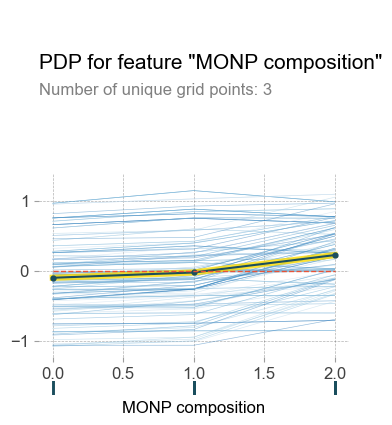

In [72]:
feature = "MONP composition"

pdp_NP_none_M = pdp.pdp_isolate(model=model,
                        dataset=X_label,
                        model_features=X_label.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=10)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(4, 5))
axes['pdp_ax']['_count_ax'].set_xlabel(feature, fontsize=12)
fig.savefig("./RCF_LabelEncoder/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

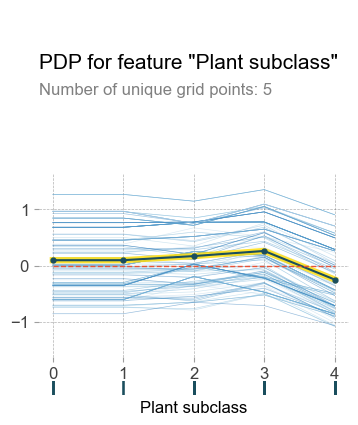

In [73]:
feature = "Plant subclass"

pdp_NP_none_M = pdp.pdp_isolate(model=model,
                        dataset=X_label,
                        model_features=X_label.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=10)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(4, 5))
axes['pdp_ax']['_count_ax'].set_xlabel(feature, fontsize=12)
fig.savefig("./RCF_LabelEncoder/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

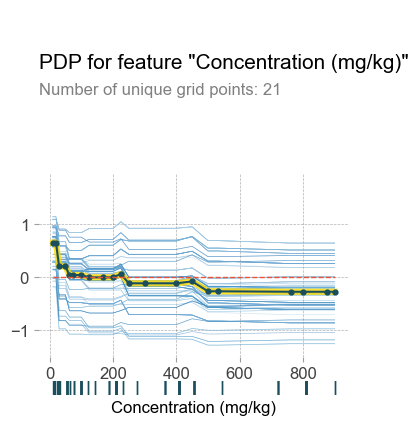

In [74]:
feature = "Concentration (mg/kg)"

pdp_NP_none_M = pdp.pdp_isolate(model=model,
                        dataset=X_label,
                        model_features=X_label.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=50)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(4, 5))
axes['pdp_ax']['_count_ax'].set_xlabel(feature, fontsize=12)
feature_save = "Concentration"
fig.savefig("./RCF_LabelEncoder/Local_PDP_%s.jpg"%feature_save,dpi=600,bbox_inches='tight') 

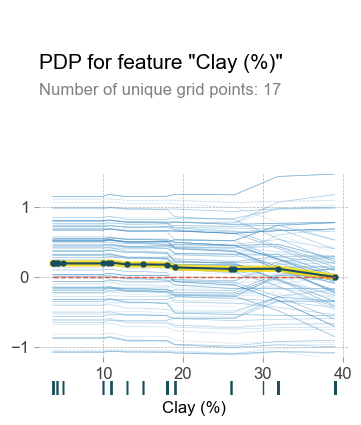

In [75]:
feature = "Clay (%)"

pdp_NP_none_M = pdp.pdp_isolate(model=model,
                        dataset=X_label,
                        model_features=X_label.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=50)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(4, 5))
axes['pdp_ax']['_count_ax'].set_xlabel(feature, fontsize=12)
fig.savefig("./RCF_LabelEncoder/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

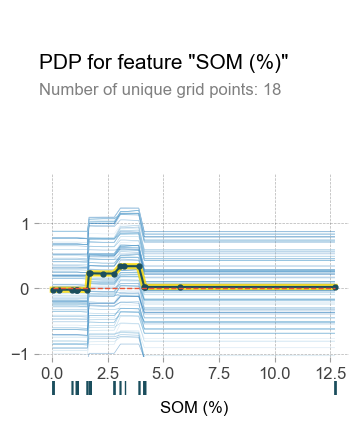

In [76]:
feature = "SOM (%)"

pdp_NP_none_M = pdp.pdp_isolate(model=model,
                        dataset=X_label,
                        model_features=X_label.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=50)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(4, 5))
axes['pdp_ax']['_count_ax'].set_xlabel(feature, fontsize=12)
fig.savefig("./RCF_LabelEncoder/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

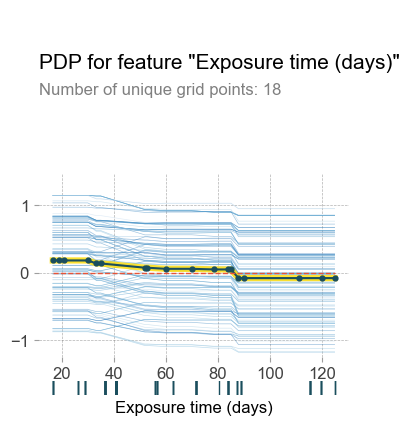

In [77]:
feature = "Exposure time (days)"

pdp_NP_none_M = pdp.pdp_isolate(model=model,
                        dataset=X_label,
                        model_features=X_label.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=50)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(4, 5))
axes['pdp_ax']['_count_ax'].set_xlabel(feature, fontsize=12)
fig.savefig("./RCF_LabelEncoder/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

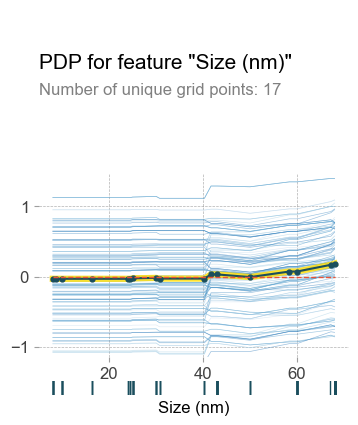

In [78]:
feature = "Size (nm)"

pdp_NP_none_M = pdp.pdp_isolate(model=model,
                        dataset=X_label,
                        model_features=X_label.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=50)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(4, 5))
axes['pdp_ax']['_count_ax'].set_xlabel(feature, fontsize=12)
fig.savefig("./RCF_LabelEncoder/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

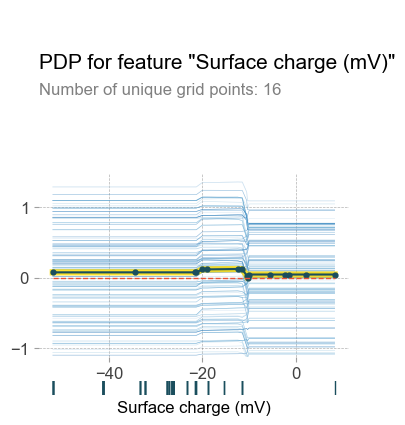

In [79]:
feature = "Surface charge (mV)"

pdp_NP_none_M = pdp.pdp_isolate(model=model,
                        dataset=X_label,
                        model_features=X_label.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=50)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(4, 5))
axes['pdp_ax']['_count_ax'].set_xlabel(feature, fontsize=12)
fig.savefig("./RCF_LabelEncoder/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

In [80]:
features

['Concentration (mg/kg)',
 'Plant subclass',
 'Clay (%)',
 'MONP composition',
 'SOM (%)',
 'Size (nm)',
 'Exposure time (days)',
 'Surface charge (mV)']